In [1]:
# Need to change to the same directory as project. Do not know why
import os
os.chdir("c:\\Users\\zhaobang\\OneDrive\\桌面\\NewKerosene")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modules.kerosenePreprocess import Kerosene
import modules.DataDrop as DD 
import modules.clustering as cs
from scipy.cluster.hierarchy import fcluster

In [2]:
kerosene = Kerosene("./raw_data/2-supply-histories-with-sensor.csv")
# some special id to drop. Apporo dont need this
kerosene.normal_use.set_index("customer_id", inplace=True)
# 1076 and 1069 are tanktype 5 and 6 respectively
kerosene.normal_use.drop([666, 663, 650, 1086,725, 614, 775, 799, 1077, 1069, 1076], inplace=True)
kerosene.normal_use.reset_index(inplace=True)
for i in range(kerosene.normal_use.shape[0]):
    if kerosene.normal_use.loc[i, "volume"] == 0:
        kerosene.normal_use.drop(i, inplace=True)
kerosene.normal_use.reset_index(inplace=True)

normal_use_in_season = DD.supply_data_drop(kerosene.normal_use.copy())

c:\Users\zhaobang\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [3]:
ID_all = pd.unique(normal_use_in_season["customer_id"])
normal_use_in_season.pop("level_0")
ID_tanktype = []

In [4]:
normal_use_in_season.head()

,customer_id,index,tank_type_id,supplied_at,volume,purpose
0,637,430,1,2016-11-07 06:53:00,302.7,NaN
1,637,431,1,2016-11-15 06:52:00,226.2,NaN
2,637,432,1,2016-11-21 05:38:00,187.3,NaN
3,637,433,1,2016-11-28 06:59:00,273.5,NaN
4,637,434,1,2016-12-05 07:07:00,222.0,NaN


In [5]:
for i in ID_all:
    df_id = normal_use_in_season[normal_use_in_season["customer_id"] == i]
    df_id.reset_index(inplace=True)
    ID_tanktype.append(df_id.loc[0, "tank_type_id"])

In [6]:
pd.Series(ID_tanktype).value_counts()

1    89
3    25
dtype: int64

In [7]:
normal_use_in_season.head()

,customer_id,index,tank_type_id,supplied_at,volume,purpose
0,637,430,1,2016-11-07 06:53:00,302.7,NaN
1,637,431,1,2016-11-15 06:52:00,226.2,NaN
2,637,432,1,2016-11-21 05:38:00,187.3,NaN
3,637,433,1,2016-11-28 06:59:00,273.5,NaN
4,637,434,1,2016-12-05 07:07:00,222.0,NaN


In [8]:
id_over = []
tankid = []
for i in range(len(normal_use_in_season["volume"])):
    if normal_use_in_season.loc[i, "volume"] > 500:
        id_over.append(normal_use_in_season.loc[i, "customer_id"])
        tankid.append(normal_use_in_season.loc[i, "tank_type_id"])
id_over_unique = pd.unique(pd.Series(id_over))

In [9]:
id_over_unique

array([ 719,  615,  715,  717,  652, 1045,  750, 1059,  804,  743,  758,
        763, 1054,  870,  869,  828,  826], dtype=int64)

In [11]:
normal_use_in_season[normal_use_in_season["customer_id"] == 1059].to_csv("./unusual_id/1059_over500.csv")

In [9]:
normal_use_in_season.set_index("customer_id", inplace=True)
# 1076 and 1069 are tanktype 5 and 6 respectively
normal_use_in_season.drop(id_over_unique, inplace=True)
normal_use_in_season.reset_index(inplace=True)

In [10]:
distance_matrix, time_data, clusterdata = cs.Calculate_linkageMatrix(normal_use_in_season, "./raw_data/weather_data.csv")

calculate distance matrix: 100%|██████████| 97/97 [03:28<00:00,  2.15s/it]


c:\Users\zhaobang\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\cluster\hierarchy.py:364: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


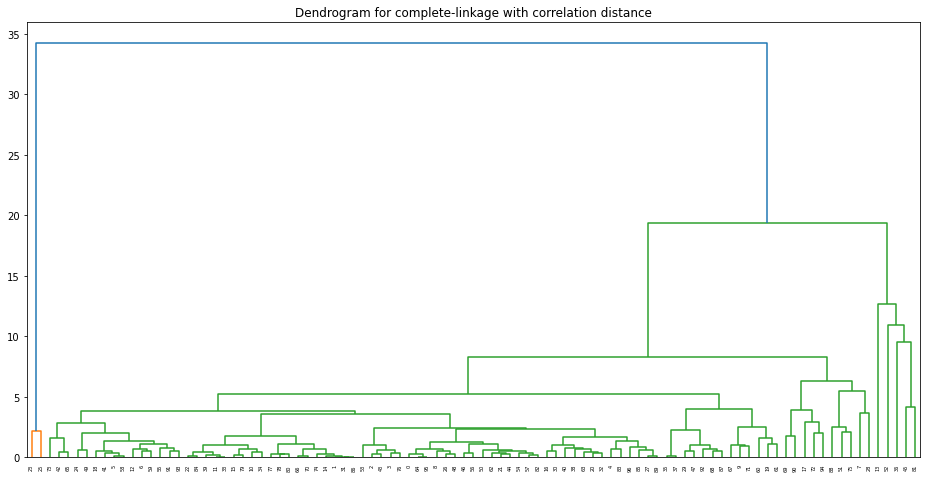

In [11]:
linkage_matrix = cs.hierarchical_clustering(distance_matrix, 1)

In [12]:
# select maximum number of clusters
cluster_labels_3 = fcluster(linkage_matrix, 5, criterion='maxclust')

# hand-select an appropriate cut-off on the dendrogram
cluster_labels_5 = fcluster(linkage_matrix, 5, criterion='distance')

In [13]:
print(np.unique(cluster_labels_5))

[ 1  2  3  4  5  6  7  8  9 10]


In [15]:
ALL_ID = list(clusterdata.keys())

In [18]:
df_cluster = {"ID": ALL_ID, "Cluster": cluster_labels_5}
df = pd.DataFrame(data=df_cluster)
df.to_csv("./ClusteringProgram/ClusterData_cc/10_clusters.csv", index=False)

In [21]:
for i in ALL_ID:
    clusterdata[i] = pd.Series(clusterdata[i])
for i in ALL_ID:
    time_data[i] = pd.Series(time_data[i])

In [22]:
cc_df =pd.DataFrame.from_dict(clusterdata)
cc_time_df = pd.DataFrame.from_dict(time_data)

In [24]:
cc_df.to_csv("./ClusteringProgram/ClusterData_cc/cc.csv", index=False)
cc_time_df.to_csv("./ClusteringProgram/ClusterData_cc/cc_time.csv", index=False)